### Budget trends in RL data

The following code uses the `all_activity_normal.cs` dataset to create trends lines for average advertising budget for the 2009-2018 period. The dataset can be found at `G:\Market\for Matt & B2B\Data\ReachLocal\Platform Data\all_activities 2009-Nov. 2018.zip` The code can be modified to create these graphs based on a variety of categories, for example business categoty or advertiser subcategory. The logic is fairly straight forward and following the comments along should be easy. The code has been automated to some extend and will be updated in the future to a turn-key code.

*Author: Farshad Nasiri - B2B Data Science Team*

In [1]:
# Import necessay libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#from datetime import datetime
#################################################################
## For including LateX interpreter
#################################################################
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

In [2]:
# Read the data
df=pd.read_csv('../data/all_activity_normal.csv')

In [3]:
# Quick look at the shape of the dataframe
#df.shape

In [4]:
# Quick look at the columns
df.columns

Index(['Unnamed: 0', 'idcampaign', 'idcampaign_master', 'idOffer',
       'Offer_Name', 'Finance_Product', 'idadvertiser', 'idadvertiser_master',
       'Advertiser_URL', 'idBusiness', 'Channel', 'Country', 'Currency',
       'campaign_budget', 'Retail_Cost', 'COGS', 'Overage', 'impressions',
       'clicks', 'CVTs', 'qualified_calls', 'calls', 'emails',
       'qualified_web_events', 'Leads', 'CPC', 'CTR', 'CPL', 'CTL', 'Paid_On',
       'Cycle_Started', 'Cycle_Ended', 'MCID_Started', 'Cycle_Number',
       'Advertiser_BC_ID', 'Advertiser_BusinessCategory', 'Advertiser_BSC_ID',
       'Advertiser_BusinessSubCategory', 'BC_ID', 'BusinessCategory',
       'Primary_BSC_ID', 'Primary_BusinessSubCategory', 'Secondary_BSC_Count',
       'Secondary_BSC_IDs', 'Seconardy_BSCs', 'BusinessSpecialtyID',
       'BusinessSpecialty', 'TargetType', 'Radius_Target_Address',
       'Radius_Target_Miles', 'Cities_Targetd', 'DMAs_Targeted',
       'Population_Target', 'ratio', 'ratio_cat'],
      dtype='

In [5]:
df.idadvertiser_master.nunique()

85686

In [6]:
# Summary of missing values
#df.isnull().sum()

In [7]:
# Convert the date columns to date-time format
df['Cycle_Started']=pd.to_datetime(df.Cycle_Started)
df['Cycle_Ended']=pd.to_datetime(df.Cycle_Ended)

In [8]:
# Remove the one row with campaign start date missing
# and reset the index
df=df[~df.Cycle_Started.isnull()]
df.reset_index(drop=True, inplace=True)

In [9]:
# Drop the columns that we won't be using for graph generation 
# in order to reduce memory load

df.drop(columns=['Unnamed: 0', 'Primary_BSC_ID', 'BusinessSpecialtyID', 'Advertiser_URL', 
                 'Country','Currency','BusinessSpecialty', 'CPC', 'CTR', 'CPL', 'CTL', 
                 'Paid_On'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
#temp=df.dropna(axis=0, subset=['BusinessCategory'])

#temp=temp[['BusinessCategory', 'campaign_budget','Cycle_Started','Cycle_Ended']]

#bc=df.BusinessCategory.unique()
#bc[-1]='Other'

In [11]:
def ma(array, window=1):  # Moving average
     return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

In [12]:
from sklearn.linear_model import LinearRegression
mdl=LinearRegression(n_jobs=4)

In [16]:
col='idadvertiser_master'

df[col].fillna('Other', inplace=True)

temp=df[[col, 'campaign_budget','Cycle_Started','Cycle_Ended']]

names=df[col].unique()

names.sort()

names=np.random.choice(names, 10)

temp=temp[temp[col].isin(names)]

row_size=len(names)

years=range(2009,2019)
col_names=[]
for year in years:
    for quarter in [1,2,3,4]:
        col_names.append(str(year)+'-Q'+str(quarter))


my_df=pd.DataFrame(data=np.zeros((row_size,4*len(years))), columns=col_names)

my_df.index=sorted(names.tolist())

for quarter in range(1,5):
    if quarter==1:
        start_str='-01-01'
        end_str='-03-31'
    if quarter==2:
        start_str='-04-01'
        end_str='-06-30'
    if quarter==3:
        start_str='-07-01'
        end_str='-09-30'
    if quarter==4:
        start_str='-10-01'
        end_str='-12-31'
    for year in years:
        start=pd.to_datetime(str(year)+start_str)
        end = pd.to_datetime(str(year)+end_str)    
        
        condition = ((temp.Cycle_Started >= start) & (temp.Cycle_Ended < end)) | \
                    ((temp.Cycle_Started >= start) & (temp.Cycle_Started < end)) & (temp.Cycle_Ended > end) | \
                    ((temp.Cycle_Ended >= start) & (temp.Cycle_Ended < end)) & (temp.Cycle_Started < start)
        if condition.sum()==0:
            continue
        temp2=temp[condition]
        
        temp2['quarter_duration']=end-start
        temp2['quarter_duration'] = temp2.apply(lambda row: row.quarter_duration.days, axis=1)
        
        temp2['campaign_dutarion']=temp.Cycle_Ended-temp.Cycle_Started
        temp2['campaign_dutarion'] = temp2.apply(lambda row: row.campaign_dutarion.days, axis=1)
        
        temp2['end_end']=end-temp2.Cycle_Ended
        temp2['end_end'] = temp2.apply(lambda row: row.end_end.days, axis=1)
        
        temp2['start_start']=temp2.Cycle_Started-start
        temp2['start_start'] = temp2.apply(lambda row: row.start_start.days, axis=1)
        
     
        temp2['budget_ratio']=(temp2.quarter_duration-(temp2.end_end+temp2.start_start))/temp2.quarter_duration
        temp2.campaign_budget=temp2.campaign_budget*temp2.budget_ratio
        
        temp2=temp2.groupby(by=[col]).agg({'campaign_budget':'sum'})
       # print(temp2.shape[0])
        temp2.sort_values(by=[col], inplace=True)
        
        my_col=str(year)+'-Q'+str(quarter)
        my_df.loc[temp2.index, my_col]=temp2.campaign_budget
#######################################################################################

#pd.set_option("display.max_columns",100)

#my_df

#from matplotlib import rc
# for i in range(0, len(my_df.index)):
#     location=i

#     plt.figure(figsize=(12,6))
#     plt.cla()
#     plt.plot(my_df.columns, my_df.iloc[location,:],'k-o')
#     plt.xticks(rotation='vertical');
#     plt.tick_params(direction='in', length=10, width=2.5, colors='k',
#                                grid_color='k', grid_alpha=1, labelsize=14)
#     plt.ylabel('Ave. Budget', fontsize=16)
#     plt.title(my_df.index[location], fontsize=16)
#     #ax = plt.gca()
    
#     save_to='../output/BC-2009-2018/'+my_df.index[location].replace(' ', '_').replace('/','')+".png"
#     plt.savefig(save_to, bbox_inches = 'tight')
#     plt.close()


In [17]:
pd.set_option("display.max_columns",100)

my_df["idadvertiser_master"]=my_df.index

my_df.reset_index(drop=True, inplace=True)

In [19]:
 my_df.to_csv('../data/master_adv_id_quarterly.csv', index=False)

In [91]:
#for i in range(0, len(my_df.index)):

threshold = 0.001
ma_window=12

seasonal=[]
period=[]
coefficient=[]
for i in range(0, len(my_df.index)):
    location=i

    time_series=np.array(my_df.iloc[location,:]).reshape(1,-1)
    time_series=time_series-ma(time_series, window=ma_window) # Remove the trend

        # Next largest power of 2        
    nfft=1<<(time_series.shape[1]-1).bit_length()

    y=np.fft.fft(time_series, n=nfft)
    y=abs(y**2)
    y=(y-y.min())
    y=y/y.max()

    freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
    freq_ts=1/freq_ts
    freq_ts=freq_ts[1:]
    freq_ts=freq_ts.reshape(-1,1)

    y=y[0][1:int(nfft/2)].reshape(1,-1).T

    period.append( (freq_ts[ np.argmax(y) ])[0] )

In [70]:
len(period)

10000

Period detected: 126.0


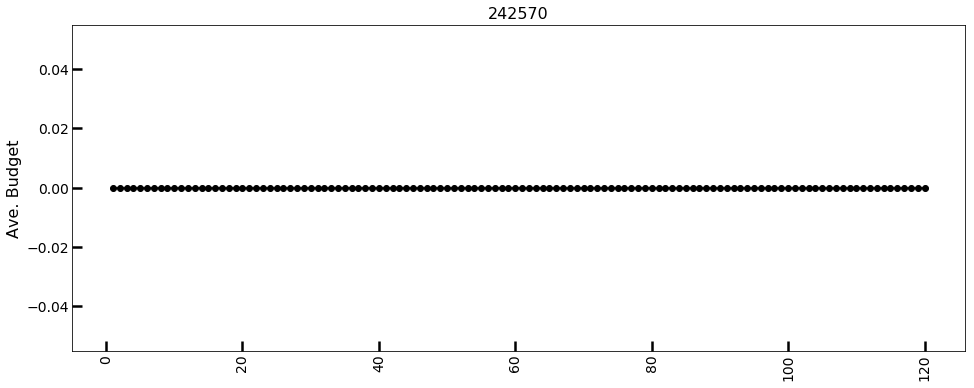

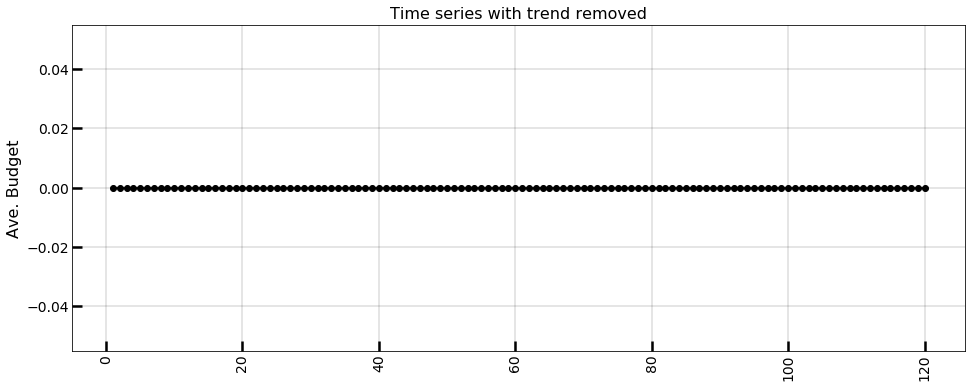

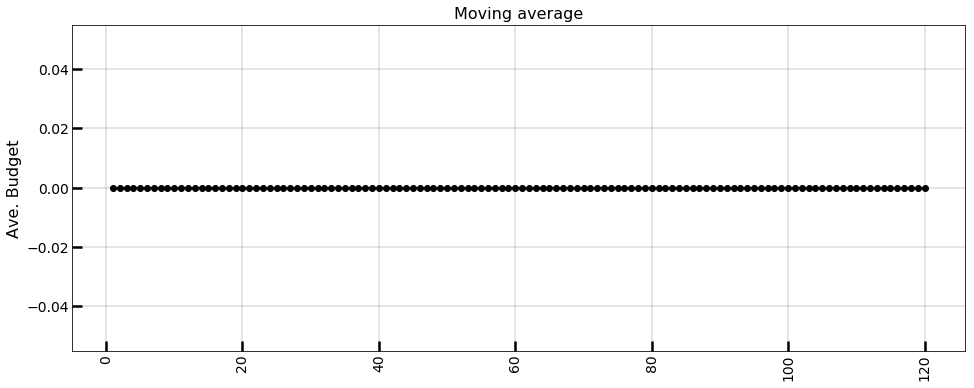

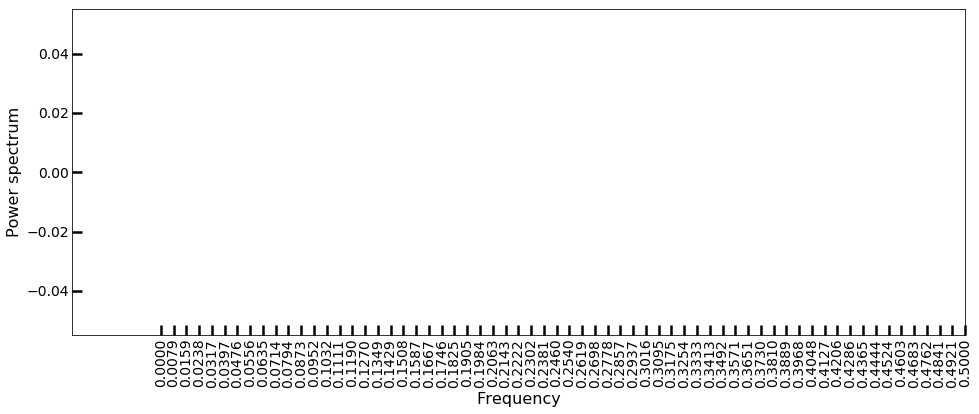

In [73]:
location=9998

#print('Seasonality detected:', seasonal[location])
print('Period detected:', period[location])

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,my_df.columns.shape[0]+1), my_df.iloc[location,:],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title(my_df.index[location], fontsize=16);

time_series=np.array(my_df.iloc[location,:]).reshape(1,-1)
mov_avg=ma(time_series, window=4)
time_series=time_series-ma(time_series, window=4)
nfft=1<<(time_series.shape[1]-1).bit_length()
freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
freq_ts=freq_ts.reshape(1,-1).T


# Perform FFT
y=np.fft.fft(time_series, n=nfft)
y=abs(y**2) # Get the power spectrum

# Scale (optional)
y=(y-y.min())
y=y/y.max()

# Reshaping because Python is stupid and doesn't take care of this 
# automatically. Boy I miss Matlab.
y=y[0][0:int(nfft/2)].reshape(1,-1).T

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,my_df.columns.shape[0]+1),time_series[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time series with trend removed', fontsize=16)
 

plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,my_df.columns.shape[0]+1),mov_avg[0],'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Moving average', fontsize=16)


plt.figure(figsize=(16,6))
plt.cla()
plt.bar(freq_ts.T[0],y.T[0], width=0.005)
plt.xticks(ticks=freq_ts.T[0],rotation='vertical');
#plt.yscale('log')
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Power spectrum', fontsize=16);
plt.xlabel('Frequency', fontsize=16);

In [74]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [105]:
#time_series.shape

In [104]:
#new_series

In [109]:
location= 12
time_series=np.array(my_df.iloc[location,:]).reshape(1,-1)
new_series=diff(time_series[0],k_diff=1, k_seasonal_diff=1, seasonal_periods=3)
test=adfuller(new_series, maxlag=new_series.shape[0]-2)

print(test[1]*100)

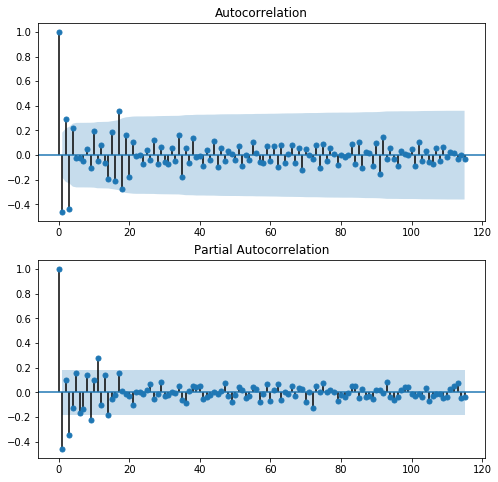

In [111]:
# ACP - PACP
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(x=new_series, ax=ax1);
plot_pacf(x=new_series, ax=ax2, method='ldb');

In [114]:
model=SARIMAX(time_series[0], order=(2, 3, 1), seasonal_order=(3, 1, 1, 5), 
              enforce_invertibility=False, enforce_stationarity=False)
res=model.fit()
pred=res.predict()

steps=1

forecast=res.forecast(steps=steps)

Text(0.5, 1.0, 'Time series with trend removed')

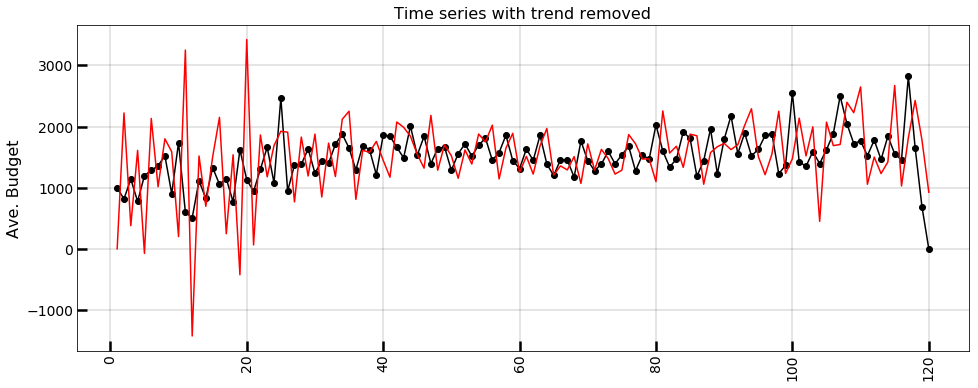

In [115]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(range(1,my_df.columns.shape[0]+1),time_series[0],'k-o')
plt.plot(range(1,my_df.columns.shape[0]+1),pred,'r-')
plt.plot(range(my_df.columns.shape[0],my_df.columns.shape[0]+steps),forecast+(pred[-1]-forecast[0]),'r-')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time series with trend removed', fontsize=16)

In [ ]:
model.p